In [1]:
import numpy as np
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial


from masking import *
from tuning import Q10RBFNet
import json

import time
import datetime
import sys

from rbf import RBFNet

In [2]:
load_json_file=True  #if True, loads params from distrib_params.json

In [3]:
results_folder=None
load_json_optim_params=False
if load_json_file:
    with open('distrib_params.json') as f:
        params = json.load(f)
        E0_distributed=params['E0_distributed']
        I0_distributed=params['I0_distributed']
        write_results=params["write_results"]
        expe_name=params["expe_name"]
        try:
            results_name=params["results_name"]
            results_folder=params["results_folder"]
        except KeyError as e:
            print('results_folder not specified, will take default value')
        results_folder0=params["results_folder0"]
        load_json_optim_params=params['load_json_optim_params']
        CFs=params['CFs']
        n_workers=int(params['n_workers'])
else:
    n_workers=4
    E0_distributed=True
    I0_distributed=True
    write_results=True
    expe_name='1-22' 
    results_folder0=f'./results/fit{expe_name}-distrib/' #if I0_distributed, loads wb cdf params from other folder

    
#NB: Q10_distributed is considered always True

### Target functions

In [4]:
def target_func(f, beta=0.7, Q_0=2.):
    #return log Q in function of freq f. No level dependance
    f0 = 1000
    return np.log10(Q_0)+beta*(torch.log10(f)-np.log10(f0))


### RBF NeuralNet for Q10

In [5]:
#n=6
#net=Q10RBFNet(n, sig=0.3)
net=Q10RBFNet.create_from_jsonfile('RBF_params.json')

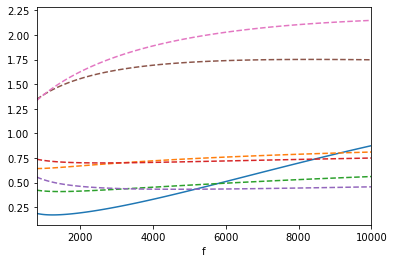

In [6]:

def plot_gauss(x, f, c, weight, sig, log=True, mult_factor=1.):
    arr=mult_factor*weight*torch.exp(- (x-c)**2/(2*sig)**2)
    if log:
        pl.plot(f, 10**arr, '--')
    else:
        pl.plot(f, arr, '--')

def plot_Q10(label='', plot_target=False, plot_rbfs=False):
    m=100
    x=torch.linspace(0,1,m)
    f = net.real_coord(x)

    out=net.forward(f)
    pl.plot(f.numpy(), 10**out.data.numpy()[:,0], label=label)
    if plot_target:
        target=target_func(f)
        pl.plot(f.numpy(), 10**target, label="target")
    if plot_rbfs:
        for i in range(net.n_centers):
            c=net.centers[i]
            weight=net.l2.weight[0, i]
            with torch.no_grad():
                plot_gauss(x, f, c, weight, net.sig)
    #pl.xscale('log')
    #pl.yscale('log')
    pl.xlabel('f')
    pl.xlim([800, 10000])
    #pl.legend()
    #pl.show()
    
plot_Q10(plot_rbfs=True)

In [7]:
net.centers

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000], requires_grad=True)

### RBF NeuralNet for I0

In [8]:
#n_I0=6
#net_I0=RBFNet(n_I0, sig=0.3)
net_I0=RBFNet.create_from_jsonfile('RBF_I0_params.json')

In [9]:
   
if not load_json_file:
    #results_folder=f'./results/fit{expe_name}/'
    CFs=[3000, 4000, 5000, 6000, 8000]

if results_folder is None:
    results_folder=f'./results/fit{expe_name}-distrib/'
I0s=[]

for CF in CFs:
    
    wb_cdf=WeibullCDF_IOFunc.load_from_npz(f'{results_folder0}/wbcfdIO_{CF}.npz')
    I0s.append(wb_cdf.I0)

def target_func_I0(f):
    return np.interp(f, CFs, I0s)

    

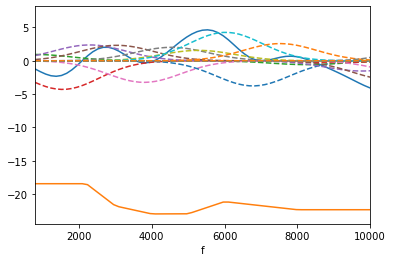

In [10]:

def plot_I0(label='', plot_target=False, plot_rbfs=False):
    m=100
    x=torch.linspace(0,1,m)
    f = net_I0.real_coord(x)

    out=net_I0.forward(f)
    pl.plot(f.numpy(), out.data.numpy()[:,0], label=label)
    if plot_target:
        target=target_func_I0(f)
        pl.plot(f.numpy(), target, label="target")
    if plot_rbfs:
        for i in range(net_I0.n_centers):
            c=net_I0.centers[i]
            weight=net_I0.l2.weight[0, i]
            with torch.no_grad():
                plot_gauss(x, f, c, weight, net_I0.sig, log=False, mult_factor=net_I0.mult_factor)
    #pl.xscale('log')
    #pl.yscale('log')
    pl.xlabel('f')
    pl.xlim([800, 10000])
    #pl.legend()
    #pl.show()
    
plot_I0(plot_rbfs=True, plot_target=True)

### Learning

Q10

In [11]:
lr = 2e-2
lr_centers=0
optimizer = optim.SGD([
    {'params':net.parameters()}, 
    {'params': [net.centers], 'lr':lr_centers}], #centers 
    lr=lr, momentum=0.9)


step : 0, loss: 0.00220, grad norm: 3.298
step : 5, loss: 0.00077, grad norm: 1.543
step : 10, loss: 0.00017, grad norm: 1.360
step : 15, loss: 0.00065, grad norm: 1.284
step : 20, loss: 0.00006, grad norm: 0.227
step : 25, loss: 0.00009, grad norm: 0.796
step : 30, loss: 0.00010, grad norm: 0.414
step : 35, loss: 0.00001, grad norm: 0.243
step : 40, loss: 0.00003, grad norm: 0.399
step : 45, loss: 0.00001, grad norm: 0.051
step : 50, loss: 0.00001, grad norm: 0.212
step : 55, loss: 0.00001, grad norm: 0.145
step : 60, loss: 0.00000, grad norm: 0.028
step : 65, loss: 0.00001, grad norm: 0.127
step : 70, loss: 0.00000, grad norm: 0.041
step : 75, loss: 0.00000, grad norm: 0.049
step : 80, loss: 0.00000, grad norm: 0.050
step : 85, loss: 0.00000, grad norm: 0.009
step : 90, loss: 0.00000, grad norm: 0.035
step : 95, loss: 0.00000, grad norm: 0.025


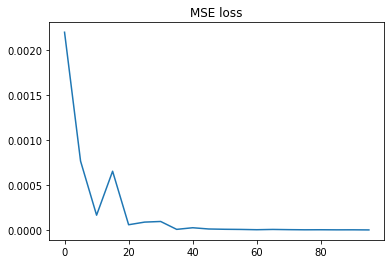

In [12]:
n_steps=100
batch_size=8
test_batch_size=256
criterion = nn.MSELoss()
verbose=True
step_test=5 #all step_test, estimate loss 
losses=[]

#mode for selectinf frequencies
#mode='random'
mode='fixed'

f_min=800.
f_max=15000.


#targetfunc=partial(target_func)

targetfunc=partial(target_func, beta=0.4, Q_0=1.5)

f_arr=torch.tensor([1500., 2200., 3000., 4000., 5000., 6000., 8000.])
for i in range(n_steps):
    optimizer.zero_grad()
    if mode =='random':
        f=f_min+(f_max-f_min)*torch.rand((batch_size, 1), requires_grad=False)
    else:
        ind=torch.randint(len(f_arr), (batch_size, 1))
        f=f_arr[ind]
    #random_values = torch.rand(batch_size,2, requires_grad=False)
    #I, f = net.real_coord(random_values[:,0], random_values[:,1])
    target=targetfunc(f)    
    target.unsqueeze_(-1)
    out=net.forward(f, verbose=(i%step_test==0))
    loss = criterion(target, out)
    loss.backward()
    optimizer.step()
    if verbose and i%step_test==0:
        #test
        
        random_values = torch.rand(test_batch_size,1, requires_grad=False)
        f = net.real_coord(random_values)
        out=net.forward(f)
        target=targetfunc(f)
        target.unsqueeze_(-1)
        loss = criterion(target, out)/test_batch_size
        grad_norm=net.l2.weight.grad.norm()
        losses.append(loss.detach().numpy())
        #print("ex:I={:.1f} dB, f={:.1f} kHz, estimate={:.2f}, target={:.2f}".format(I[0].item(), f[0].item(),10**out[0].item(), 10**target[0].item()))
        print("step : {}, loss: {:.5f}, grad norm: {:.3f}".format(i, loss.data, grad_norm))
        
pl.figure()
pl.title("MSE loss")
pl.plot(range(0,n_steps, step_test), losses[0::])
pl.show()

I0

In [13]:
lr = 1e-3
lr_centers=0
optimizer_I0 = optim.SGD([
    {'params':net_I0.parameters()}, 
    {'params': [net_I0.centers], 'lr':lr_centers}], #centers 
    lr=lr, momentum=0.9)


step : 0, loss: 1.38568, grad norm: 561.966
step : 5, loss: 1.35251, grad norm: 440.508
step : 10, loss: 1.13000, grad norm: 331.827
step : 15, loss: 0.76716, grad norm: 281.446
step : 20, loss: 0.79208, grad norm: 339.419
step : 25, loss: 0.86508, grad norm: 127.500
step : 30, loss: 0.76922, grad norm: 117.823
step : 35, loss: 0.84567, grad norm: 241.839
step : 40, loss: 0.73498, grad norm: 229.462
step : 45, loss: 0.82260, grad norm: 127.630
step : 50, loss: 0.74868, grad norm: 76.905
step : 55, loss: 0.66120, grad norm: 85.731
step : 60, loss: 0.63176, grad norm: 36.561
step : 65, loss: 0.78082, grad norm: 64.485
step : 70, loss: 0.61503, grad norm: 53.182
step : 75, loss: 0.63449, grad norm: 159.018
step : 80, loss: 0.70577, grad norm: 52.914
step : 85, loss: 0.64324, grad norm: 83.953
step : 90, loss: 0.69885, grad norm: 151.572
step : 95, loss: 0.57675, grad norm: 87.947
step : 100, loss: 0.70271, grad norm: 75.301
step : 105, loss: 0.66845, grad norm: 119.372
step : 110, loss: 0

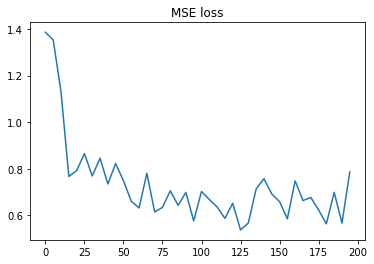

In [14]:
n_steps=200
batch_size=8
test_batch_size=256
criterion = nn.MSELoss()
verbose=True
step_test=5 #all step_test, estimate loss 
losses=[]

#mode for selectinf frequencies
mode='random'
#mode='fixed'

f_min=800.
f_max=10000.


targetfunc=target_func_I0

f_arr=torch.tensor([1500., 2200., 3000., 4000., 5000., 6000., 8000.])
for i in range(n_steps):
    optimizer_I0.zero_grad()
    if mode =='random':
        f=f_min+(f_max-f_min)*torch.rand((batch_size, 1), requires_grad=False)
    else:
        ind=torch.randint(len(f_arr), (batch_size, 1))
        f=f_arr[ind]
    #random_values = torch.rand(batch_size,2, requires_grad=False)
    #I, f = net.real_coord(random_values[:,0], random_values[:,1])
    target=targetfunc(f)    
    target=torch.tensor(target, dtype=torch.float)
    target.unsqueeze_(-1)
    out=net_I0.forward(f, verbose=(i%step_test==0))
    loss = criterion(target, out)
    loss.backward()
    optimizer_I0.step()
    if verbose and i%step_test==0:
        #test
        
        random_values = torch.rand(test_batch_size,1, requires_grad=False)
        f = net_I0.real_coord(random_values)
        out=net_I0.forward(f)
        target=targetfunc(f)
        target=torch.tensor(target, dtype=torch.float)
        target.unsqueeze_(-1)
        loss = criterion(target, out)/test_batch_size
        grad_norm=net_I0.l2.weight.grad.norm()
        losses.append(loss.detach().numpy())
        #print("ex:I={:.1f} dB, f={:.1f} kHz, estimate={:.2f}, target={:.2f}".format(I[0].item(), f[0].item(),10**out[0].item(), 10**target[0].item()))
        print("step : {}, loss: {:.5f}, grad norm: {:.3f}".format(i, loss.data, grad_norm))
        
pl.figure()
pl.title("MSE loss")
pl.plot(range(0,n_steps, step_test), losses[0::])
pl.show()

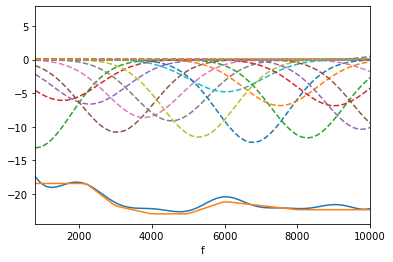

In [15]:

    
plot_I0(plot_rbfs=True, plot_target=True)

### Distributed learning

In [16]:

import torch.distributed as dist

from datetime import timedelta

In [17]:
backend=dist.Backend('gloo')

In [18]:
dist.init_process_group(backend, init_method='tcp://127.0.0.1:1234', world_size=n_workers, rank=0, 
                        timeout=datetime.timedelta(0, 80))  

In [19]:
if E0_distributed:
    with open('E0_params.json') as f:
        params = json.load(f)        
        f_min=float(params['f_min'])
        f_max=float(params['f_max'])
        m=int(params['m'])

    E0=1/2*torch.ones((m,), dtype=torch.float64)

    #pl.plot(np.linspace(f_min*1e-3, f_max*1e-3, m), E0)
    #pl.xlabel('Frequency (kHz)')
    #pl.ylabel('Init raw excitation')

In [20]:
def wait_handle(h, timeout=10, interval=0.02, name=''):
    start = time.time()
    
        
    #should be the normal way to go but it is bugged:
    '''while (not h.is_completed()) and time.time() - start < timeout:
        time.sleep(interval)
    '''
    try:
        h.wait()
    except RuntimeError as e:
        print(e)
        print(f'handle [{name}] not completed before timeout')
        
    

def wait_list_handles(l, names=None, timeout=10):
    for i, handle in enumerate(l):
        name = None if names is None else names[i]
        #handle.wait()
        wait_handle(handle, name=name, timeout=timeout)

Send weights for RBF net (Q10)

In [21]:
send_handles=[]
handle_names=[]
for rank in range(1, n_workers):
    handle=dist.isend(net.l2.weight, rank, tag=7)
    handle_name = f'update weights RBF rank {rank}'
    send_handles.append(handle)
    handle_names.append(handle_name)

wait_list_handles(send_handles, names=handle_names, timeout=10)

Send weights for RBF net (I0)

In [22]:
send_handles=[]
handle_names=[]
for rank in range(1, n_workers):
    handle=dist.isend(net_I0.l2.weight, rank, tag=17)
    handle_name = f'update weights RBF I0 rank {rank}'
    send_handles.append(handle)
    handle_names.append(handle_name)

wait_list_handles(send_handles, names=handle_names, timeout=10)

optim params

In [23]:
if load_json_optim_params:
    with open('optim_params.json') as f:
        dic_params=json.load(f)
    
    #n_it=dic_params['n_it'] #not used as sent by other nodes
    #nb_steps=dic_params['nb_steps'] #not used as sent by other nodes
    #n_dim=dic_params['n_dim'] #proj done by other nodes
    step_values=dic_params['alpha']
    alpha_I0=float(step_values['I0RBFweights'])

    alpha=alpha_Q10=float(step_values['Q10RBFweights'])
    
    alpha_E0=float(step_values['E0'])
else:
    alpha=alpha_Q10=1.5
    alpha_E0=6
    alpha_I0=0.15



optim loop

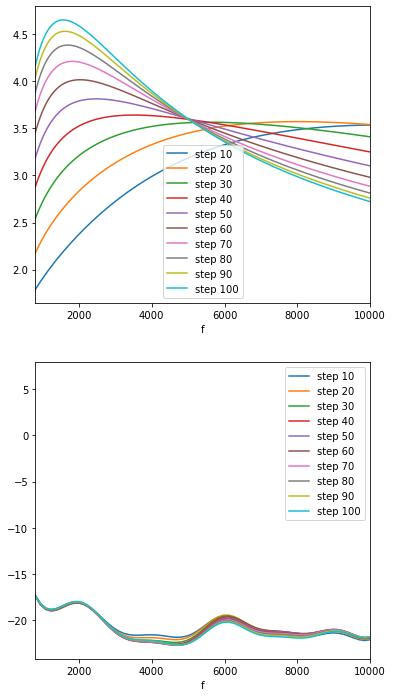

In [24]:
it_step_plot=10
k_it=0
    
nb_steps_arr=torch.ones((n_workers-1,), dtype=torch.int32)


if E0_distributed:
    grad_E0=torch.zeros_like(E0, dtype=torch.float64)
grad=torch.zeros_like(net.l2.weight)
grad_I0=torch.zeros_like(net_I0.l2.weight)

pl.figure(figsize=(6, 12))


ax1=pl.subplot(2,1,1)
ax2=pl.subplot(2,1,2)
while True:
    
    
    optim_done_handles=[]
    handle_names=[]
    for rank in range(1, n_workers):
        if nb_steps_arr[rank-1]>0:
            optim_done_handles.append(dist.irecv(nb_steps_arr[rank-1], rank, tag=16))
            handle_names.append(f'nb steps it {k_it} rank {rank}')
    wait_list_handles(optim_done_handles, names=handle_names)
    
    if torch.count_nonzero(nb_steps_arr) == 0:
        break
        
        
    #update E0
    if E0_distributed:   
        send_handles=[]
        handle_names=[]
        for rank in range(1, n_workers):  #the other nodes update weights at start of loop
            if nb_steps_arr[rank-1]>0:
                send_handles.append(dist.isend(E0, rank, tag=8))
                handle_names.append(f'update E0 it {k_it} rank {rank}')

        wait_list_handles(send_handles, names=handle_names)
    
    
    
    #update Q10
    send_handles=[]
    handle_names=[]
    for rank in range(1, n_workers):  #the other nodes update weights at start of loop
        if nb_steps_arr[rank-1]>0:
            send_handles.append(dist.isend(net.l2.weight, rank, tag=7))
            handle_names.append(f'update RBF weights it {k_it} rank {rank}')

    wait_list_handles(send_handles, names=handle_names)
    
    
    #update I0
    if I0_distributed:
        send_handles=[]
        handle_names=[]
        for rank in range(1, n_workers):  #the other nodes update weights at start of loop
            if nb_steps_arr[rank-1]>0:
                send_handles.append(dist.isend(net_I0.l2.weight, rank, tag=17))
                handle_names.append(f'update RBF weights (I0) it {k_it} rank {rank}')

        wait_list_handles(send_handles, names=handle_names)


    
    
    max_nb_steps=int(torch.amax(nb_steps_arr))
                     
    if E0_distributed:
        for step in range(1, max_nb_steps+1):
            for rank in range(1, n_workers): #gradients are forwarded by the other nodes
                if step<=nb_steps_arr[rank-1]:  
                    hand = dist.irecv(grad_E0, src=rank, tag=2000+step)
                    wait_handle(hand, name=f'grad E0 it {k_it} step {step} rank {rank}')
                    E0.data-=alpha_E0*grad_E0
                    
    if I0_distributed:
        for step in range(1, max_nb_steps+1):
            for rank in range(1, n_workers): #gradients are forwarded by the other nodes
                if step<=nb_steps_arr[rank-1]:  
                    hand = dist.irecv(grad_I0, src=rank, tag=3000+step)
                    wait_handle(hand, name=f'grad RBF weights (I0) it {k_it} step {step} rank {rank}')
                    net_I0.l2.weight.data-=alpha_I0*grad_I0
                    
    for step in range(1, max_nb_steps+1):
        for rank in range(1, n_workers): #gradients are forwarded by the other nodes
            if step<=nb_steps_arr[rank-1]:  
                hand=dist.irecv(grad, src=rank, tag=1000+step)
                wait_handle(hand, name=f'grad RBF weights it {k_it} step {step} rank {rank}')
                net.l2.weight.data-=alpha*grad

        
    k_it+=1
    
    if k_it%it_step_plot==0:
        pl.sca(ax1)
        plot_Q10(label=f'step {k_it}')
        pl.sca(ax2)
        plot_I0(label=f'step {k_it}')
        
pl.sca(ax1) 
pl.legend()

pl.sca(ax2) 
pl.legend()

pl.show()


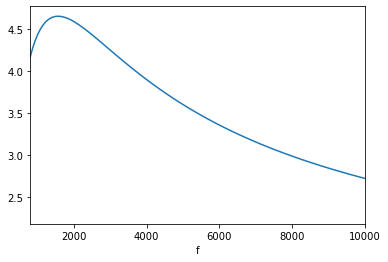

In [25]:
plot_Q10()

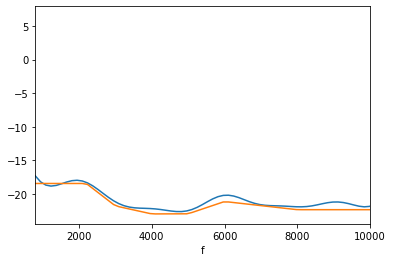

In [26]:
plot_I0(plot_target=True)

In [27]:
if write_results:    
    m=100
    x=torch.linspace(0,1,m)
    f = net.real_coord(x)
    out=net.forward(f)
    Q10_val=10**out.data.numpy()[:,0]
    
    np.savez(f'{results_folder}/Q10.npz', f=f.detach().numpy(), Q10=Q10_val )
    
    np.savez(f'{results_folder}/Q10_RBF_weights.npz',weights=net.l2.weight.data )
    
    
    if I0_distributed:
            m=100
            x=torch.linspace(0,1,m)
            f = net_I0.real_coord(x)
            out=net_I0.forward(f)
            I0_val=out.data.numpy()[:,0]

            np.savez(f'{results_folder}/I0_from_RBF.npz', f=f.detach().numpy(), I0=I0_val )
            np.savez(f'{results_folder}/I0_RBF_weights.npz', weights=net_I0.l2.weight.data )
        